In [176]:
######## (c)
import wrds
db=wrds.Connection(wrds_username='harpersss')
import numpy as np
import pandas as pd
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1990-01-01'"
            "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

#use own index instead
# get index returns
data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1900-01-01'"
            "and date<='2021-12-31'", date_cols=['date'])


# get stock returns
crsp_m = db.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc, a.hsiccd 
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2021'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
msf=crsp_m.drop(['shrcd','exchcd'],axis=1)
del(crsp_m) 

#variables
msf['permno'] = msf['permno'].astype(int)
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['const'] = 1
msf.sort_values(['permno','date'])

msf['size_lag']= msf.groupby('permno')['size'].shift(1).to_frame()

obs=msf[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
msf = pd.merge(msf, obs, how='left', left_on=['permno'],right_on=['permno'])



#################################
# Compute excess returns
#################################
data_index = pd.merge(data_index, Rf, how='left', left_on=['date'],right_on='date')
data_index['mprem']=(data_index['vwretd']-data_index['rf'])
data = pd.merge(msf, data_index, how='left', left_on=['date'],right_on='date')
data['exret']=data['ret']-data['rf']

data=data[data.obs==384]
#Get 1995 year
data_filter = data[(data['date'] > '1995-01-01') & (data['date'] < '1995-12-30')]
data_unique = data_filter.drop_duplicates(subset=['permno'])
data_unique["market-capitalization"] = data_unique["shrout"] * data_unique["prc"]
data_unique = data_unique.nlargest(100,"market-capitalization")
data = data[data["permno"].isin(data_unique["permno"].values)]


Loading library list...
Done


/var/folders/0y/tdn01_bx09j8xn5wzkr9fsy40000gn/T/ipykernel_19674/2796096028.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique["market-capitalization"] = data_unique["shrout"] * data_unique["prc"]


In [177]:
index_data = pd.read_csv('12_Industry_Portfolios.csv').rename(columns = {'Date':'date','Hlth ':'Hlth'})
index_data = index_data[(index_data['date'] >= 199001) & (index_data['date'] <= 202112)]
index_data = index_data.reset_index().drop(columns=['index','date'])
index_data = index_data/100
data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1990-01-01'"
            "and date<='2021-12-31'", date_cols=['date'])
index = pd.concat([data_index,index_data],axis=1) #real portfolio return data

Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1990-01-01'"
            "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})
Rf = Rf.drop(columns={'date'})
index = pd.concat([index,Rf],axis=1)

In [178]:
def get_industry(number):
    
    if(((number>=100) and (number<=999)) or (number>=2000 and number<=2399) or  (number>=2700 and number<=2749) or  (number>=2770 and number<=2799) or  (number>=3100 and number<=3199)  or  (number>=3940 and number<=3989)):
        return  "NoDur"

    if((number>=2500 and number<=2519) or (number>=2590 and number<=2599) or (number>=3630 and number<=3659) or (number>=3710 and number<=3711) or (number>=3714 and number<=3714) or (number>=3716 and number<=3716) or (number>=3750 and number<=3751) or (number>=3792 and number<=3792) or (number>=3900 and number<=3939) or  (number>=3900 and number<=3939)):
        return "Durbl"
    
    if((number>=2520 and number<=2589) or  (number>=2600 and number<=2699) or  (number>=2750 and number<=2769) or  (number>=3000 and number<=3099) or (number>=3200 and number<=3569) or (number>=3580 and number<=3629) or (number>=3700 and number<=3709) or(number>=3712 and number<=3713) or(number>=3715 and number<=3715) or(number>=3717 and number<=3749) or(number>=3752 and number<=3791) or(number>=3793 and number<=3799) or(number>=3830 and number<=3839) or(number>=3860 and number<=3899)):
        return "Manuf"
    
    if((number>=1200 and number<=1399) or  (number>=2900 and number<=2999)):
        return "Enrgy"
    
    if((number>=2800 and number<=2829) or  (number>=2840 and number<=2899)):
        return "Chems"
    
    if((number>=3570 and number<=3579) or  (number>=3660 and number<=3692) or (number>=3694 and number<=3699) or  (number>=3810 and number<=3829) or  (number>=7370 and number<=7379)):
        return "BusEq"
    
    if((number>=4800 and number<=4899)):
        return "Telcm"
    
    if((number>=4900 and number<=4949)):
        return "Utils"
    
    if((number>=5000 and number<=5999) or  (number>=7200 and number<=7299) or (number>=7600 and number<=7699)):
        return "Shops"
    
    if((number>=2830 and number<=2839) or  (number>=3693 and number<=3693) or (number>=3840 and number<=3859)  or (number>=8000 and number<=8099)):
        return "Hlth"
    
    if((number>=6000 and number<=6999)):
        return "Money"
    
    else:
        return "Other"

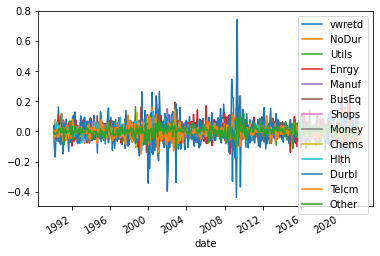

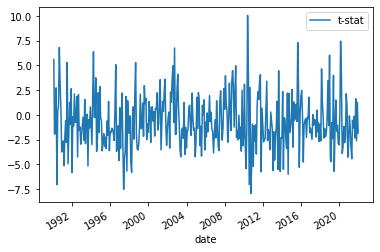

average t-statistic associated with each factor. 0:t_value 1: p_value
NoDur seems have biggest influence


,vwretd,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,-2.565552,-3.715512,-1.768518,-3.042694,-1.825302,-3.268314,-3.290093,-2.784768,-3.011830,-2.698427,-3.157222,-2.472916,-1.911291
1,0.010490,0.000218,0.077372,0.002425,0.068345,0.001130,0.001047,0.005489,0.002682,0.007120,0.001655,0.013618,0.056340


In [179]:
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
exposure = pd.DataFrame()
i = 0
stock_list = data['permno'].unique()
for stock in stock_list:
    exposure.loc[i,'permno'] = stock
    test = data[(data['permno']==stock)]
    slope = stats.linregress(test['ret'], index['vwretd']-index['rf']).slope #beta to the market
    exposure.loc[i,'vwretd'] = slope
    indus = get_industry(test.iloc[0,5])
    exposure.loc[i,indus] = 1
    i+=1
exposure = exposure.fillna(0)


factor_return = exposure.drop(index = exposure.index).rename(columns={'permno':'date'})
i = 0
x = sm.add_constant(exposure.drop(columns = {'permno'}))
for d in data['date'].unique():
    y = data[data['date']==d]['ret'].reset_index().drop(columns = {'index'})
    res = sm.OLS(y,x).fit()
    factor_return.loc[i] = res.params
    factor_return.loc[i,'date'] = d
    # t-statistics
    t,aaa = stats.ttest_ind(np.array(res.params[1:]),np.array(index[index['date']==d].drop(columns={'date','rf'}))[0])
    factor_return.loc[i,'t-stat'] = t
    i+=1
### Plot the time-series of estimated factor returns.    
fig_df = factor_return.set_index('date').drop(columns={'t-stat'})
fig_df.plot()
plt.show()
### Plot the time series of the monthly t-statistics
fig_df = factor_return.set_index('date')[['t-stat']]
fig_df.plot()
plt.show()

t_report = pd.DataFrame()
for col in index.drop(columns=['date','rf']).columns.values.tolist():
    t,pvalue = stats.ttest_ind(factor_return[col],index[col])
    t_report.loc[0,col] = t
    t_report.loc[1,col] = pvalue
print("average t-statistic associated with each factor. 0:t_value 1: p_value")
print('NoDur seems have biggest influence')
t_report

* How do you interpret the fact that certain t-statistics vary widely over time from +4 to -4 say?
* In different time, different factor has different influence to its price. This is also associate with the economics. For example, because of the war in Ukraine, now the energy price rises up very quickly, and it can also lead to stock price change. So currently, energy should be an impoertant factor in this model

In [180]:
#######(d)
data['value'] = data['size']*data['prc']
data["avg_ret"] = np.zeros(38400)
for stock in data["permno"].unique():
    data["avg_ret"][data["permno"] == stock] = data[data["permno"] == stock]["ret"].rolling(11,11).sum()
    #shift by 1 (we calculate t-11 to t so we need to shift it by 1 )
    for i in range(len(data[data["permno"] == stock]) - 1):
        if(i>=11):
            data["avg_ret"][data["permno"] == stock].iloc[i] = data["avg_ret"][data["permno"] == stock].iloc[i+1]
data

/var/folders/0y/tdn01_bx09j8xn5wzkr9fsy40000gn/T/ipykernel_19674/2655334021.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["avg_ret"][data["permno"] == stock] = data[data["permno"] == stock]["ret"].rolling(11,11).sum()


,permno,date,ret,shrout,prc,hsiccd,size,const,size_lag,obs,vwretd,rf,mprem,exret,value,avg_ret
6721,10516,1990-01-31,-0.134054,281065.0,20.000000,2046.0,5.621300e+06,1,NaN,384,-0.070114,0.006390,-0.076503,-0.140444,1.124260e+08,NaN
6855,10516,1990-02-28,0.050000,281065.0,21.000000,2046.0,5.902365e+06,1,5.621300e+06,384,0.014900,0.006441,0.008459,0.043559,1.239497e+08,NaN
6856,10516,1990-03-30,0.083333,283801.0,22.750000,2046.0,6.456473e+06,1,5.902365e+06,384,0.024148,0.006688,0.017460,0.076645,1.468848e+08,NaN
6857,10516,1990-04-30,0.034066,283801.0,23.500000,2046.0,6.669324e+06,1,6.456473e+06,384,-0.028283,0.006283,-0.034567,0.027782,1.567291e+08,NaN
6858,10516,1990-05-31,0.127660,283801.0,26.500000,2046.0,7.520726e+06,1,6.669324e+06,384,0.088935,0.006132,0.082803,0.121528,1.992993e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400562,70519,2021-08-31,0.063443,2026785.0,71.910004,6021.0,1.457461e+08,1,1.397738e+08,384,0.027147,0.000034,0.027113,0.063409,1.048060e+10,0.627326
400563,70519,2021-09-30,-0.024058,2026785.0,70.180000,6021.0,1.422398e+08,1,1.457461e+08,384,-0.042243,0.000038,-0.042281,-0.024096,9.982387e+09,0.630640
400564,70519,2021-10-29,-0.007267,2026785.0,69.160004,6021.0,1.401725e+08,1,1.422398e+08,384,0.064657,0.000042,0.064614,-0.007309,9.694328e+09,0.293822
400565,70519,2021-11-30,-0.078947,1984267.0,63.700001,6021.0,1.263978e+08,1,1.401725e+08,384,-0.018347,0.000068,-0.018414,-0.079015,8.051541e+09,0.095209


In [181]:
import datetime
exposure_d = exposure.drop(index = exposure.index).rename(columns={'permno':'date'})
j = 0
t = 1
for d in data['date'].unique()[10:-1]: # calculate exposure to factor when date=d+1 (equal to having a date shift herer)
        #d: weight calculation time  d_1: real time
        d_1 = data['date'].unique()[10+t]
        weights_l = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]#(data[data['date']==d].nlargest(10,"avg_ret")['value'] / data[data['date']==d].nlargest(10,"value").sum()[-1]).to_list() #value weighted in long stocks
        weights_s = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]#(data[data['date']==d].nsmallest(10,"avg_ret")['value'] / data[data['date']==d].nsmallest(10,"value").sum()[-1]).to_list() #value weighted in short stocks
        permno_l = (data[data['date']==d].nlargest(10,"avg_ret")['permno']).to_list()
        permno_s = (data[data['date']==d].nsmallest(10,"avg_ret")['permno']).to_list()
        exposure_tmp = exposure.drop(index = exposure.index)
        ret = 0
        hedge = 0
        for i in range(10):
                exposure_tmp = exposure_tmp.append(weights_l[i]*exposure[exposure['permno']==permno_l[i]])
                ret += float(data[(data['date']==d_1)&(data['permno']==permno_l[i])]['ret']*weights_l[i])
        for i in range(10):
                exposure_tmp = exposure_tmp.append(-weights_s[i]*exposure[exposure['permno']==permno_s[i]])
                ret -= float(data[(data['date']==d_1)&(data['permno']==permno_s[i])]['ret']*weights_s[i])

        exposure_d.loc[j] = exposure_tmp.sum(axis=0)[1:]
        exposure_d.loc[j,'date'] = d_1
        exposure_d.loc[j,'ret'] = ret
        for name in exposure.drop(columns='permno').columns.values: #loop for all the industry portfolio, calculate hedge
                hedge += exposure_d.loc[j,name]*index[index['date']==d_1][name]
        exposure_d.loc[j,'hedge'] = float(hedge)
        j+=1
        t+=1

In [182]:
x = sm.add_constant(exposure_d.drop(columns = {'date','ret','hedge'}))
y = exposure_d['ret']
res = sm.OLS(y,x).fit()
print('In all the industry, exposure to vmretd(market) and NoDur is the largest. We will choose these two factor to analyse')
res.params

In all the industry, exposure to vmretd(market) and NoDur is the largest. We will choose these two factor to analyse


const    -0.006624
vwretd    0.109225
NoDur    -0.047021
Utils    -0.021948
Enrgy     0.019615
Manuf     0.002138
BusEq    -0.062949
Shops     0.009339
Money     0.023805
Chems     0.093737
Hlth     -0.034748
Durbl     0.008209
Telcm     0.026707
Other    -0.016884
dtype: float64

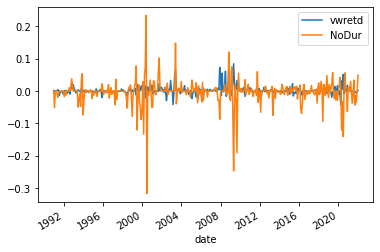

hedge mean:  -0.003590570649548488
hedge std:  0.05843075319416003
sharpe ratio:  -0.0614500148169809


In [183]:
factor_return_d = exposure.drop(index = exposure.index).rename(columns={'permno':'date'})
i = 0
for d in data['date'].unique()[11:]:
    x = sm.add_constant(exposure_d[exposure_d['date']==d].drop(columns = {'date','ret'}))
    y = exposure_d[exposure_d['date']==d]['ret']
    res = sm.OLS(y,x).fit()
    factor_return_d.loc[i] = res.params
    factor_return_d.loc[i,'date'] = d
    # t-statistics
    t,aaa = stats.ttest_ind(np.array(res.params[1:]),np.array(index[index['date']==d].drop(columns={'date','rf'}))[0])
    factor_return_d.loc[i,'t-stat'] = t
    i+=1
fig_df = factor_return_d[['date','vwretd','NoDur']].set_index('date')
fig_df.plot()
plt.show()

#Compute the return to your momentum portfolio where you hedge the exposure to all industry factors
exposure_d['hedge_ret'] = exposure_d['ret'] - exposure_d['hedge']
exposure_d['hedge_ret']
print('hedge mean: ',exposure_d['hedge_ret'].mean())
print('hedge std: ',exposure_d['hedge_ret'].std())
print('sharpe ratio: ',exposure_d['hedge_ret'].mean()/exposure_d['hedge_ret'].std())

<AxesSubplot:>

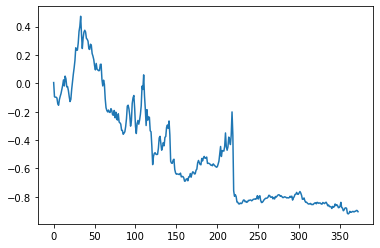

In [184]:
cum_returns = (1 + exposure_d["ret"]).cumprod() - 1
cum_returns.plot()

In [185]:
exposure_d

,date,vwretd,NoDur,Utils,Enrgy,Manuf,BusEq,Shops,Money,Chems,Hlth,Durbl,Telcm,Other,ret,hedge,hedge_ret
0,1990-12-31T00:00:00.000000000,-0.017037,0.3,0.0,0.0,-0.1,0.0,0.4,-0.7,0.0,0.2,-0.1,0.0,0.0,0.005593,-0.011473,0.017065
1,1991-01-31T00:00:00.000000000,-0.009320,0.3,0.0,-0.1,-0.2,-0.1,0.3,-0.5,0.2,0.2,-0.1,0.0,0.0,-0.099767,-0.015147,-0.084620
2,1991-02-28T00:00:00.000000000,-0.021535,0.3,0.0,-0.1,-0.2,0.0,0.4,-0.4,0.0,0.2,-0.2,0.0,0.0,-0.002998,-0.001763,-0.001235
3,1991-03-28T00:00:00.000000000,-0.016617,0.3,0.0,-0.2,-0.3,0.0,0.2,-0.1,0.0,0.3,-0.2,0.0,0.0,0.000080,0.032049,-0.031970
4,1991-04-30T00:00:00.000000000,0.003935,0.3,0.0,-0.2,-0.3,-0.1,0.2,-0.1,0.0,0.3,-0.1,0.0,0.0,-0.006564,-0.003057,-0.003507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2021-08-31T00:00:00.000000000,-0.032873,-0.4,-0.1,0.2,0.1,0.0,0.1,0.3,0.0,-0.2,0.1,0.0,-0.1,0.041180,-0.000882,0.042062
369,2021-09-30T00:00:00.000000000,-0.058027,-0.3,0.0,0.2,0.1,0.0,0.1,0.2,-0.1,-0.2,0.1,0.0,-0.1,0.012233,0.046711,-0.034478
370,2021-10-29T00:00:00.000000000,-0.036500,-0.2,-0.2,0.4,0.1,0.0,0.0,0.2,-0.2,0.0,0.0,0.0,-0.1,0.059374,0.019970,0.039404
371,2021-11-30T00:00:00.000000000,0.019240,-0.2,-0.1,0.5,-0.2,0.0,0.1,0.1,-0.1,0.0,0.1,-0.1,-0.1,-0.009667,-0.007663,-0.002004


The hedge doesn't have a high sharpe ratio and doesn't have a high excess return, which means this strategy can explain the market well.